In [1]:
#                                                                     
# Copyright (C) 2020 MakerPunch channel                                  
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.                                 
#
# This program is distributed in the hope that it will be useful,     
# but WITHOUT ANY WARRANTY; without even the implied warranty of      
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
#

import ezdxf
import ezdxf.addons.geo
from imp import reload
import ezdxf.addons.drawing
import collections
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
doc = ezdxf.readfile('./angle_iron_flat.dxf')

In [3]:
for e in doc.modelspace():
    print(e)

LINE(#100)
LWPOLYLINE(#101)
LWPOLYLINE(#102)
LINE(#103)
LWPOLYLINE(#104)
LWPOLYLINE(#105)
CIRCLE(#106)
CIRCLE(#107)
CIRCLE(#108)
LINE(#109)
LINE(#110)
LINE(#111)


Ignoring bend line
Ignoring bend line
Ignoring bend line


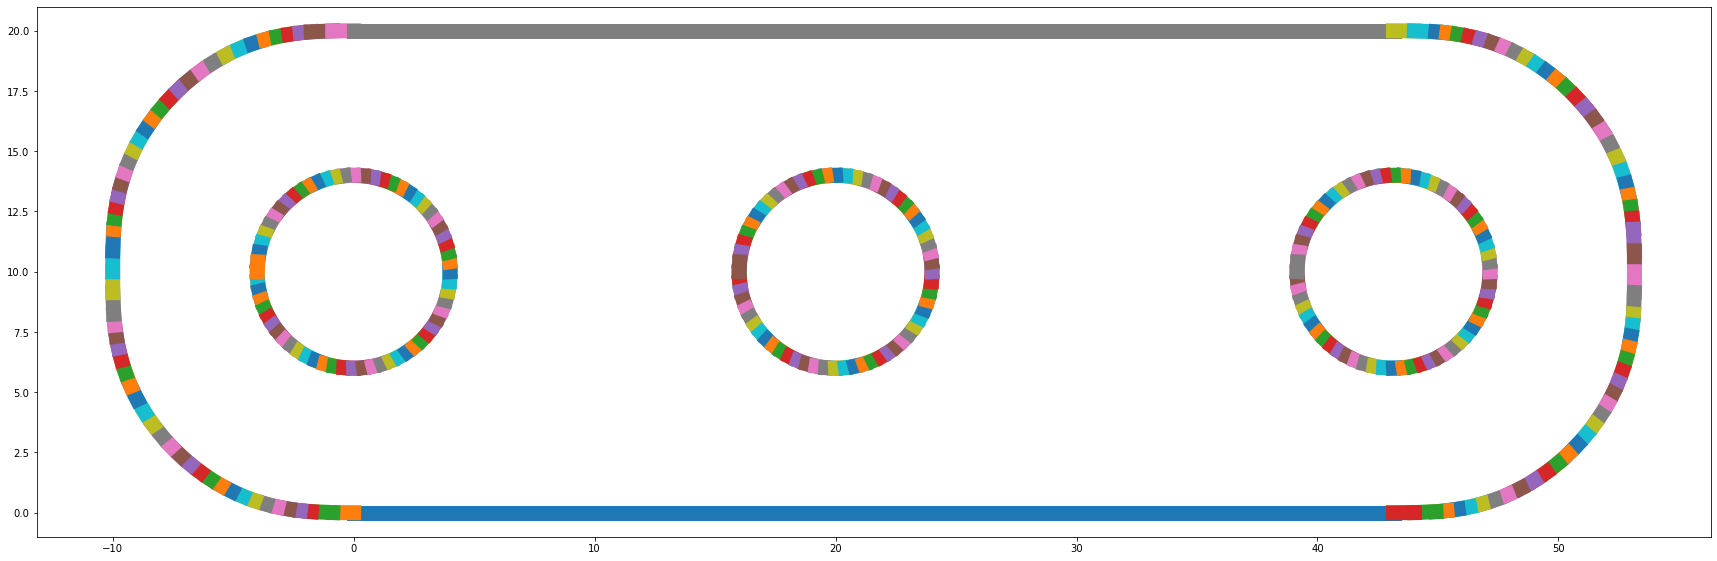

In [4]:
class LineBackend(ezdxf.addons.drawing.backend.Backend):
    def __init__(self):
        super().__init__()
        self._lines = []
    def draw_line(self, start, end, props):
        if True:
            if props.layer.startswith('BEND'):
                print('Ignoring bend line')
                return
        self._lines.append(((start[0], start[1]), (end[0], end[1])))
    def clear(self):
        pass
    def draw_point(self):
        print('pt')
    def draw_text(self):
        raise NotImplementedError()
    def get_font_measurements(self):
        raise NotImplementedError()
    def get_text_line_width(self):
        raise NotImplementedError()
    def set_background(self, *args, **kwargs):
        pass
    def draw_filled_polygon(self):
        raise NotImplementedError()
        
            

ctx = ezdxf.addons.drawing.RenderContext(doc)
be = LineBackend()
ezdxf.addons.drawing.Frontend(ctx, be).draw_layout(doc.modelspace(), finalize=True)

f, ax = subplots(figsize=(30,20))
ax.set_aspect(1)
for line in be._lines:
    l = np.array(line)
    plot(l[:, 0], l[:, 1], linewidth=15)

In [5]:
class LineCombiner:
    def __init__(self, lines):
        self.vert_to_lines = collections.defaultdict(set)
        self.lines = set()
        for line in lines:
            self.add_line(line)
    
    def add_line(self, line):
        self.lines.add(line)
        self.vert_to_lines[line[0]].add(line)
        self.vert_to_lines[line[-1]].add(line)
    
    def remove_line(self, line):
        self.lines.remove(line)
        self.vert_to_lines[line[0]].remove(line)
        self.vert_to_lines[line[-1]].remove(line)
        
    def delete_vertex(self, vertex):
        assert len(self.vert_to_lines[vertex]) == 2
        l0, l1 = self.vert_to_lines[vertex]
        self.remove_line(l0)
        self.remove_line(l1)
        if l0[0] == vertex:
            l0 = l0[::-1]
        assert l0[-1] == vertex
        if l1[-1] == vertex:
            l1 = l1[::-1]
        assert l1[0] == vertex
        line = l0 + l1[1:]
        self.add_line(line)
      
    def simplify(self):
        for v in self.vert_to_lines.keys():
            if len(self.vert_to_lines[v]) == 2:
                self.delete_vertex(v)

lc = LineCombiner(be._lines)
lc.simplify()

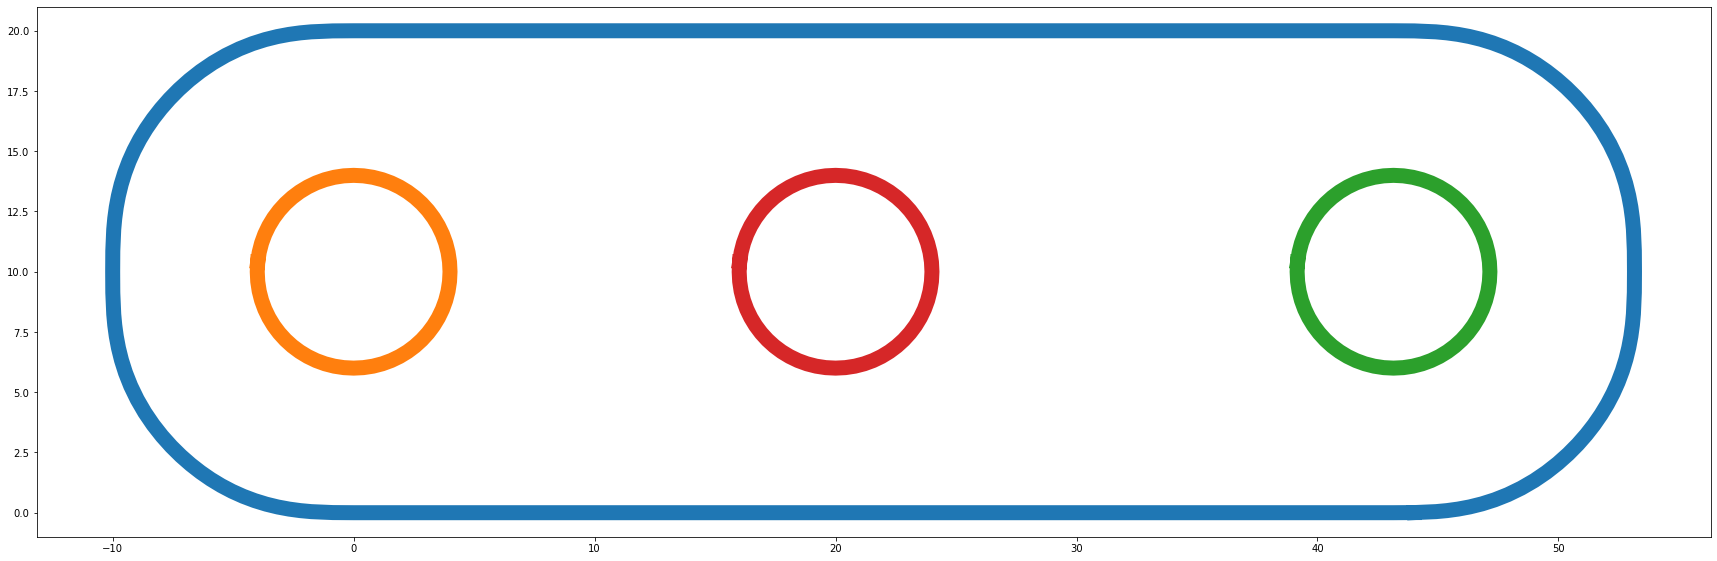

In [6]:
f, ax = subplots(figsize=(30, 20))
ax.set_aspect(1)

for line in lc.lines:
    a = np.array(line + line[0:1])
    plot(a[:, 0], a[:, 1], linewidth=15)
    

In [8]:
# NOTE: Get plycutter from https://github.com/tjltjl/plycutter
# Make sure you have its dependencies installed.
import sys
sys.path.append('../plycutter/')

from plycutter.geometry.geom2d import Geom2D

In [9]:
import gmpy2
shrink = 1
def convert_coord(c):
    if c == 0:
        return gmpy2.mpq(0)
    c = gmpy2.mpfr(c)
    return gmpy2.f2q(c / shrink, abs(0.0003 / c))

In [10]:
geoms = []
for line in lc.lines:
    assert line[0] == line[-1]
    geoms.append(Geom2D.polygon([
        (convert_coord(c[0]), convert_coord(c[1]))
        for c in line[:-1]
    ], reorient=True))

In [11]:
g = geoms[0]._arrangement_op(geoms, lambda *bools: np.sum(bools) % 2 == 1)

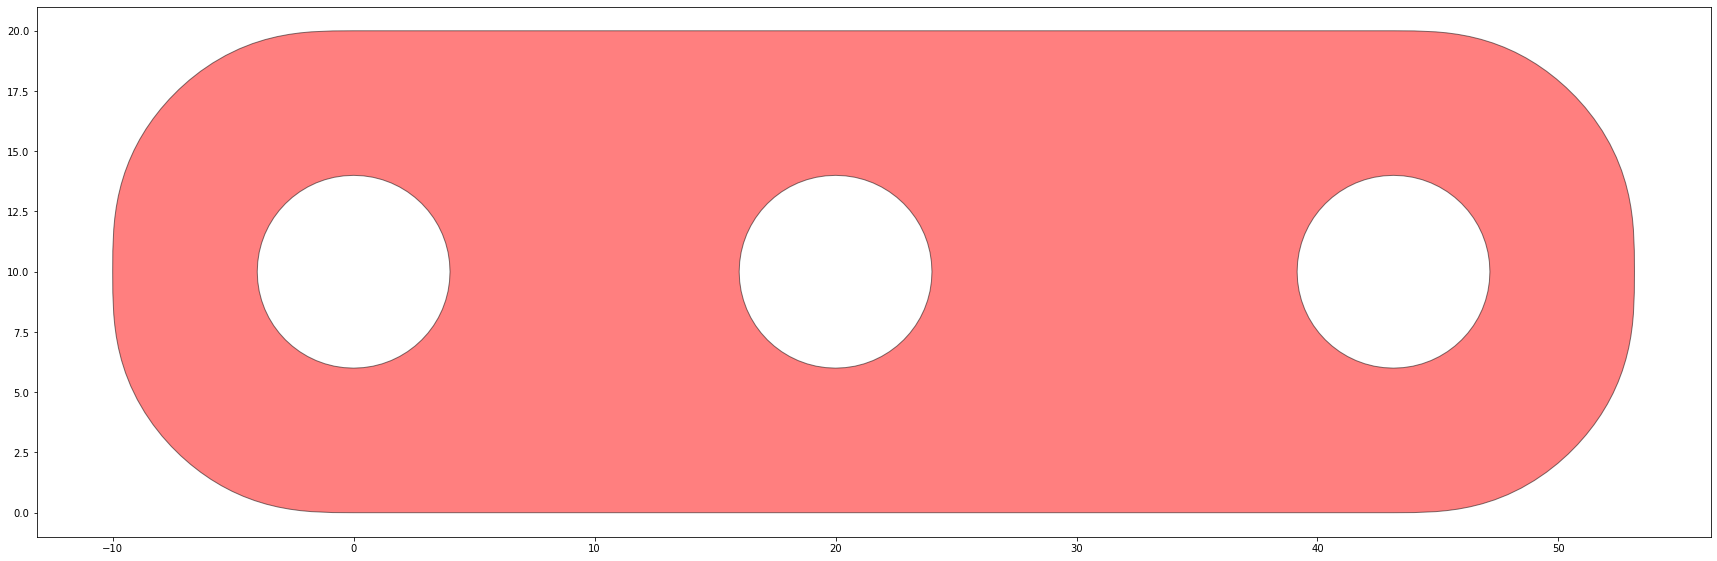

In [12]:
fig, ax = subplots(figsize=(30, 20))
g.show2d(ax, 'r', alpha=.5, linewidth=1)

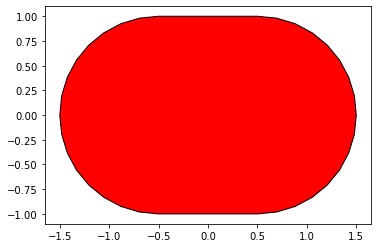

In [13]:
def transform_pt(pt, xy, xvec):
    return (
        pt[0] * xvec[0] + -pt[1] * xvec[1] + xy[0],
        pt[0] * xvec[1] + pt[1] * xvec[0] + xy[1],
    )

class OblongPunch:
    def __init__(self, dlarge, dsmall):
        """An oblong punch sitting at origin.

        Oblongness along x.

        Two circles of diameter dsmall, distance (dlarge - dsmall) apart,
        connected by linear segments.
        """
        self.dlarge = dlarge
        self.dsmall = dsmall

    def create_geom2d(self, n_segments=8, xy=(0, 0), xvec=(1, 0)):
        e = self.dlarge - self.dsmall
        x = e / 2
        y = self.dsmall / 2

        pts = [(-x, y), (x, y)]
        amult = math.pi / n_segments
        for i in range(n_segments - 1):
            pts.append(
                (x + math.sin((i + 1) * amult),
                 math.cos((i + 1) * amult)))

        pts = [(convert_coord(pt[0]), convert_coord(pt[1]))
                for pt in pts]
        pts = pts + [(-pt[0], -pt[1]) for pt in pts]
        pts = [transform_pt(pt, xy, xvec) for pt in pts]

        return Geom2D.polygon(pts)

fig, ax = subplots()
punch = OblongPunch(3, 2)
gp = punch.create_geom2d(n_segments=16)
gp.show2d(ax, 'red', linewidth=1)

In [14]:
class PunchedHole:
    def __init__(self, punch, xy, xvec):
        """A hole punched by a punch.

        xy -- (x, y): The center of the punch
        xvec -- (xx, xy): The x rotation vector
        """
        assert abs(xvec[0] ** 2 + xvec[1] ** 2) - 1 < 1e-8
        self.punch = punch
        self.xy = xy
        self.xvec = xvec

    def create_geom2d(self):
        return self.punch.create_geom2d(xy=self.xy, xvec=self.xvec)

F = gmpy2.mpq

def oblong_punch_along_curve(punch, vertices, separation_ratio, closed=False):
    """Generate punch locations on the path, equally spaced.
    """
    if closed:
        vertices = list(vertices) + list(vertices[0:1])
    # Compute length of the path
    length = 0
    prev = vertices[0]
    for cur in vertices[1:]:
        length += math.hypot(cur[0] - prev[0], cur[1] - prev[1])
        prev = cur

    separation = (punch.dlarge - punch.dsmall) * separation_ratio
    n_punches = math.ceil(length / separation)
    if n_punches <= 1:
        raise Exception("Too short")

    idx = 1
    over = 0
    punch_idx = 0
    holes = []
    while punch_idx < n_punches:
        prev = vertices[idx - 1]
        cur = vertices[idx]
        d = (cur[0] - prev[0], cur[1] - prev[1])
        segment_length = math.hypot(d[0], d[1])
        if over > segment_length and idx < len(vertices) - 1:
            idx += 1
            over -= segment_length
            continue
        unit_d = (F(d[0] / segment_length), F(d[1] / segment_length))
        pt = (F(prev[0] + unit_d[0] * over), F(prev[1] + unit_d[1] * over))
        holes.append(PunchedHole(punch, pt, unit_d))
        over += separation
        punch_idx += 1
    return holes


holes = []
gb = g.buffer(1, resolution=24)
holes.extend(oblong_punch_along_curve(punch, gb.exterior(), separation_ratio=1, closed=1))
for h in gb.holes():
    holes.extend(oblong_punch_along_curve(punch, h, separation_ratio=1, closed=1))

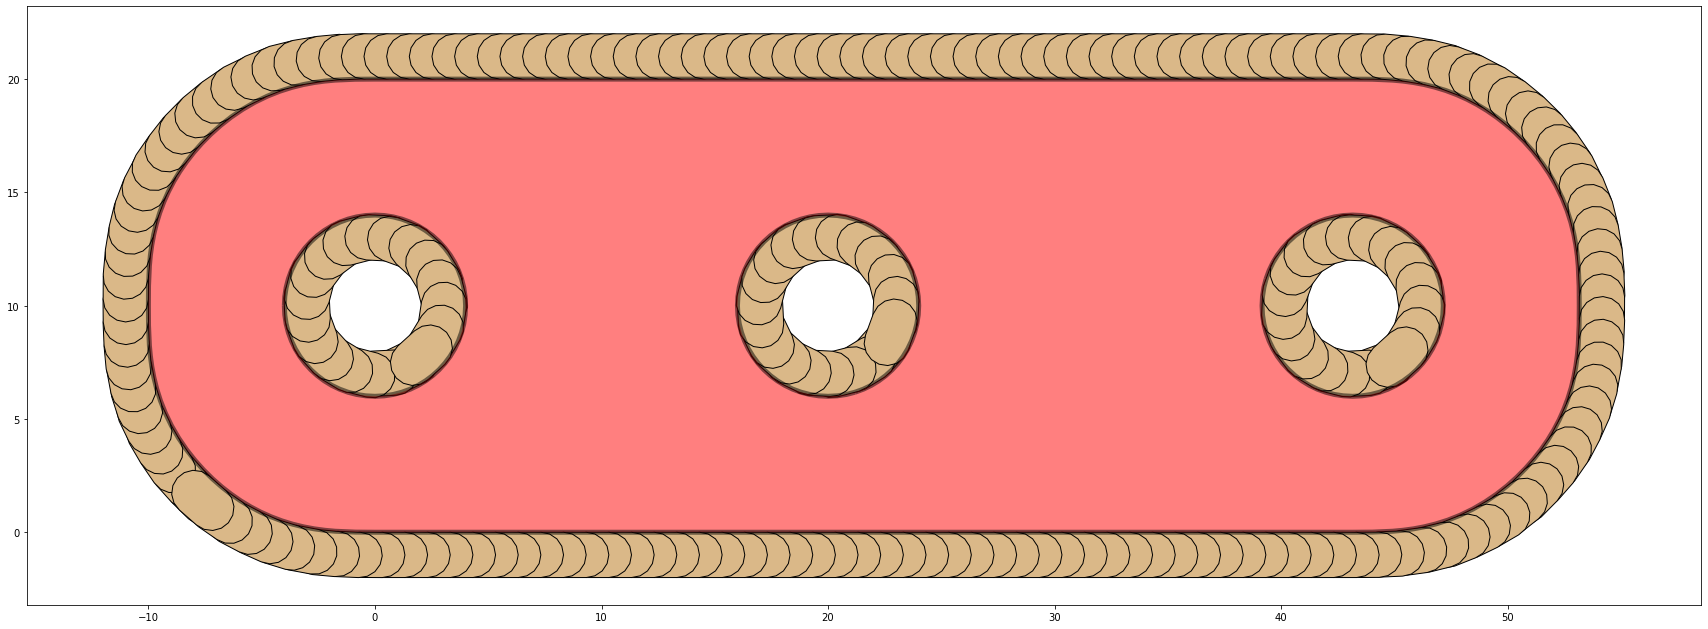

In [16]:
fig, ax = subplots(figsize=(30,30))
for hole in holes:
    hole.create_geom2d().show2d(ax, color="#dab888", linewidth=1)
g.show2d(ax, 'r', alpha=.5, linewidth=5)

In [17]:
def post(holes, depth):
    code = []
    code.append("G54\nG21 G0 Z0\nG0 X0 Y0\n")
    for hole in holes:
        # code.append("G0 X%f Y%f A%f\nG0 Z%f\nG0 Z0\n" % (hole.xy[0], hole.xy[1], math.atan2(hole.xvec[1], hole.xvec[0]) / math.pi * 180, depth))
        code.append("G0 X%f Y%f\nG0 Z%f\nG0 Z0\n" % (hole.xy[0], hole.xy[1], depth))
    return "".join(code)

s = post(holes, -1)
with open('/tmp/gcode.nc', 'w') as f:
    f.write(s)
print(s)


G54
G21 G0 Z0
G0 X0 Y0
G0 X-7.875256 Y1.648847
G0 Z-1.000000
G0 Z0
G0 X-8.567206 Y2.370158
G0 Z-1.000000
G0 Z0
G0 X-9.191273 Y3.150941
G0 Z-1.000000
G0 Z0
G0 X-9.726280 Y3.995038
G0 Z-1.000000
G0 Z0
G0 X-10.172897 Y4.889308
G0 Z-1.000000
G0 Z0
G0 X-10.521579 Y5.825691
G0 Z-1.000000
G0 Z0
G0 X-10.758601 Y6.796314
G0 Z-1.000000
G0 Z0
G0 X-10.913253 Y7.784067
G0 Z-1.000000
G0 Z0
G0 X-10.979204 Y8.781587
G0 Z-1.000000
G0 Z0
G0 X-10.998593 Y9.781243
G0 Z-1.000000
G0 Z0
G0 X-10.994975 Y10.781222
G0 Z-1.000000
G0 Z0
G0 X-10.953295 Y11.780270
G0 Z-1.000000
G0 Z0
G0 X-10.834549 Y12.772858
G0 Z-1.000000
G0 Z0
G0 X-10.639598 Y13.753238
G0 Z-1.000000
G0 Z0
G0 X-10.338897 Y14.706031
G0 Z-1.000000
G0 Z0
G0 X-9.933966 Y15.619815
G0 Z-1.000000
G0 Z0
G0 X-9.441236 Y16.489444
G0 Z-1.000000
G0 Z0
G0 X-8.849286 Y17.294922
G0 Z-1.000000
G0 Z0
G0 X-8.185936 Y18.042495
G0 Z-1.000000
G0 Z0
G0 X-7.452041 Y18.720919
G0 Z-1.000000
G0 Z0
G0 X-6.654705 Y19.323531
G0 Z-1.000000
G0 Z0
G0 X-5.799394 Y19.840059
G0 Z-1

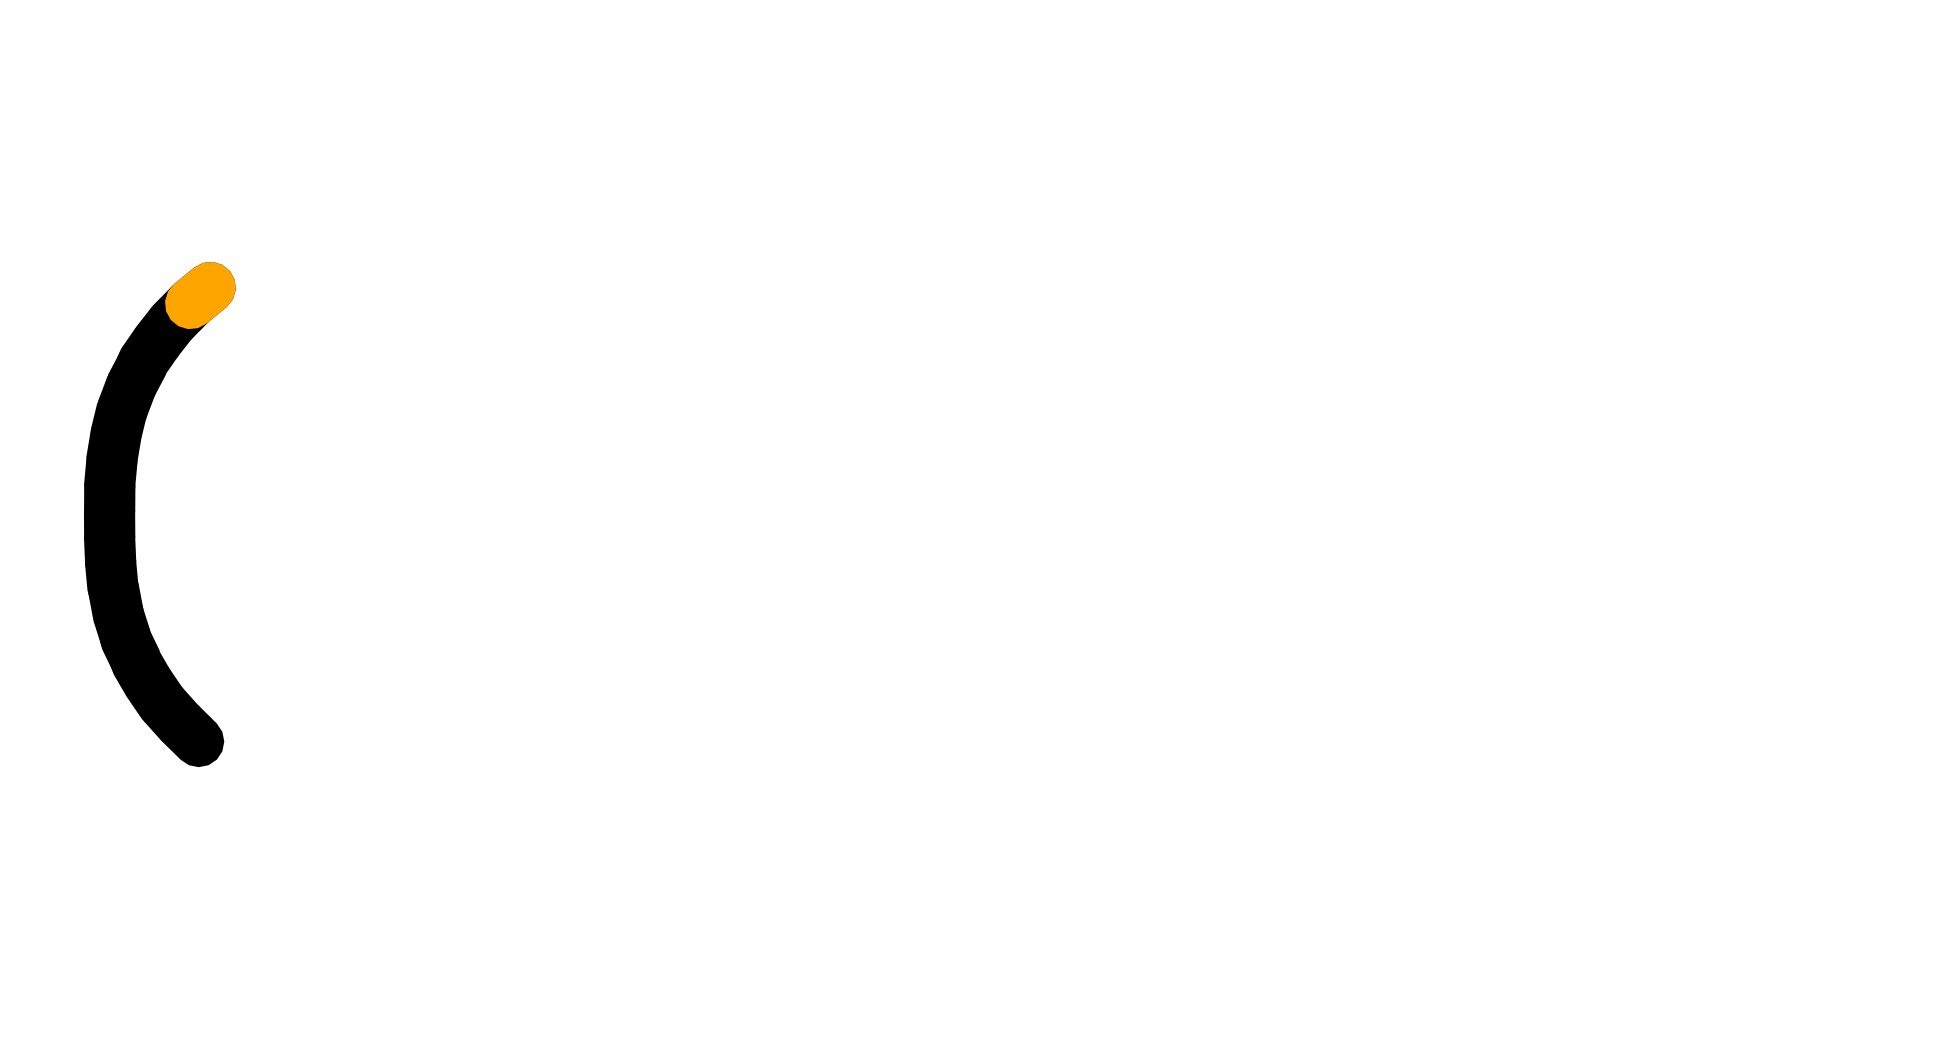

In [18]:
px = 1./plt.rcParams['figure.dpi']
fig = figure(figsize=(1920*px, 1080*px))
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.set_axis_off()
ax.set_aspect(1)
ax.set_xlim(-15, 60)
ax.set_ylim(-10, 30)
for hole in holes[0:20]:
    hole.create_geom2d().show2d(ax, 'black', linewidth=0)
hole.create_geom2d().show2d(ax, 'orange', linewidth=0)